In [53]:
#DECLARAÇÃO DE BIBLIOTECAS

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from sklearn.datasets import make_moons
from scipy.special import erfc
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

In [24]:
#GERAÇÃO DE DADOS

x, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

Y=y

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

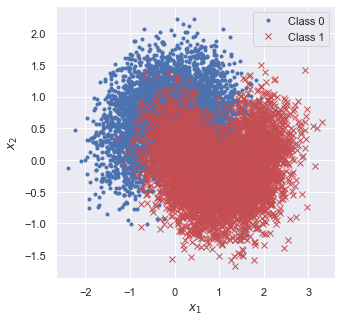

In [25]:
#PLOT GRAFICO DOS DADOS GERADOS

idx0 = np.argwhere(Y == 0)
idx1 = np.argwhere(Y == 1)

fig = plt.figure(figsize=(5,5))
plt.plot(x[idx0,0], x[idx0,1], '.', label='Class 0')
plt.plot(x[idx1,0], x[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [38]:
#GRID SEARCH

param_grid = [{'max_leaf_nodes': range(0,100)}]

classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=3, n_jobs=-1)

#treino
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'max_leaf_nodes': range(0, 100)}],
             pre_di

In [39]:
grid_search.best_params_

{'max_leaf_nodes': 33}

In [40]:
#PREDIÇÃO

y_pred = grid_search.predict(x_test)

In [41]:
#DADO DE PRECISÃO

precisao = accuracy_score(y_test, y_pred)

print('Precisão do modelo: ', precisao)

Precisão do modelo:  0.8632


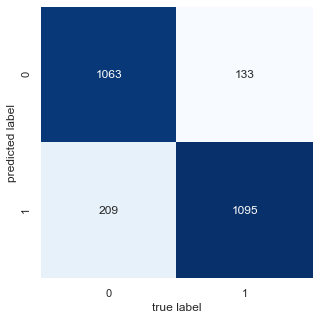

In [42]:
#PLOT MATRIZ DE CONFUSAO

# Plot the confusion matrix
fig = plt.figure(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1'], yticklabels=['0','1'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

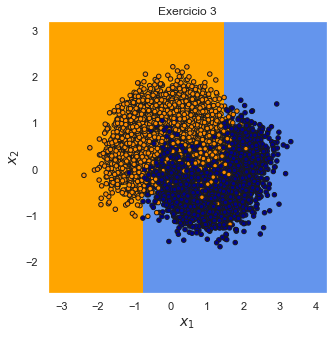

In [43]:
#FRONTEIRAS DE DECISÃO

# Step size in the mesh.
h = .02 

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

plt.figure(figsize=(5, 5))
# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = grid_search.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points.
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title("Exercicio 3")
plt.show()

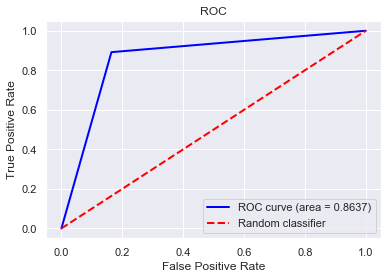

In [44]:
#PLOT CURVA ROC

# Calculating ROC curve and ROC AUC.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
# Plotting ROC curve.
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [49]:
#DIVISÃO EM SUBCONJUNTOS

#parametrização
rs = ShuffleSplit(n_splits=1000, test_size=len(x_train) - 100, random_state=42)

sub_conjuntos = []

#criação dos subconjuntos
for index_treinamento, index_validacao in rs.split(x_train):
    X_sub_conjunto = x_train[index_treinamento]
    Y_sub_conjunto = y_train[index_treinamento]
    sub_conjuntos.append((X_sub_conjunto, Y_sub_conjunto))
    


In [52]:
#TREINAMENTO DOS SUBCONJUNTOS

#clone dos melhores hiperparâmetros de treinamento para cada uma das mil arvores
floresta = [clone(grid_search.best_estimator_) for _ in range(1000)]

#armazenamento da precisão
accuracy = []

#treino de cada uma das mil árvores
for arvore, (X_sub_conjunto, Y_sub_conjunto) in zip(floresta, sub_conjuntos):
    arvore.fit(X_sub_conjunto, Y_sub_conjunto)
    
    y_pred = arvore.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))

np.mean(accuracy)

0.7931304

In [54]:
#GERAÇÃO DE PREDIÇÕES

Y_pred_floresta = np.empty([1000, len(x_test)], dtype=np.uint8)

for index_arvore, arvore in enumerate(floresta):
    Y_pred_floresta[index_arvore] = arvore.predict(x_test)
    
Y_pred_mode, contador = mode(Y_pred_floresta, axis=0)

In [57]:
#TESTE DA MELHOR

accuracy_score(y_test, Y_pred_mode.reshape(len(y_test),1))

0.8668

In [ ]:
#AUMENTOU MUITO POUCO :/